# Step 3: Optimization with uncertain conversion rates

In [25]:
# fixed graph weights (same click influence probabilities between the products for each user)
# homogeneous users (one class with small variability)
# fixed alphas (same number of users each day distributed equally between the initial webpages)
# uncertain conversion rates

In [26]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from Environment.E_commerce import *
from Algorithms.Conv_rates_Learner import *
from Algorithms.Greedy_Learner import *
from Algorithms.TS_Learner import *
from Algorithms.UCB_Learner import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
P1 = Product(0,[19.99, 21.99, 23.99, 26.99],np.multiply([0.2, 0.2, 0.2, 0.2],[19.99, 19.99, 19.99, 19.99])+[0, 21.99-19.99, 23.99-19.99, 26.99-19.99])
# t-shirt
P2 = Product(1,[29.99, 32.59, 35.99, 39.99],np.multiply([0.2, 0.2, 0.2, 0.2],[29.99, 29.99, 29.99, 29.99])+[29.99, 32.59, 35.99, 39.99]-29.99)
# shirt
P3 = Product(2,[25.99,28.99, 31.99, 34.99],np.multiply([0.3, 0.3, 0.3, 0.3],[25.99,25.99, 25.99, 25.99])+[25.99,28.99, 31.99, 34.99]-25.99)
# shorts
P4 = Product(3,[38.99,43.99,46.99, 49.99],np.multiply([0.4, 0.4, 0.4, 0.4],[38.99,38.99,38.99, 38.99])+[38.99,43.99,46.99, 49.99]-38.99)
# pants
P5 = Product(4,[79.99,89.99, 99.99, 109.99],np.multiply([0.5, 0.5, 0.5, 0.5],[79.99,79.99, 79.99, 79.99])+[79.99,89.99, 99.99, 109.99]-79.99)
# shoes

products = [P1,P2,P3,P4,P5]
margins_matrix = np.zeros((5,4))
for i in range(5):
    for j in range(4):
        margins_matrix[i,j] = products[i].margins_list[j]
print("Margin matrix: ")
print(margins_matrix)

E = E_commerce()
E.graph = np.array([[0. , 0., 1. , 0.5 , 0. ],[0. , 0. , 0.5 , 1., 0. ],[0.5 , 1. , 0. , 0. , 0. ],[1. , 0.5 , 0. , 0. , 0. ],[0. , 0.5 , 0. , 1. , 0. ]])
E.set_products(products)
E.set_lambda(0.5)

Margin matrix: 
[[ 3.998  5.998  7.998 10.998]
 [ 5.998  8.598 11.998 15.998]
 [ 7.797 10.797 13.797 16.797]
 [15.596 20.596 23.596 26.596]
 [39.995 49.995 59.995 69.995]]


Using a simple algorithm trained for a long time (1000 days, repeated 10 times), we obtain an estimation of conversion rates and expected rewards of the arms for each product. This will be considered our clairvoyant solution.

In [59]:
# Random algorithm which for each round pulls a random choice
# to estimate asymptotically the conv_rates and the mean of the number of units sold per product,
# useful for computing clairvoyant solution and regrets of the bandit algorithms


n_arms = 4
num_users = 100 #mean number of users for each day
n_days = 1000
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
num_experiments = 3
opt_vector = np.zeros(num_experiments)
conv_rates_per_experiment = []
mean_units_sold_per_product_per_experiment = []
cr_learner_expected_rewards_per_experiment = []

for e in range(num_experiments):
    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = cr_learner.pull_arm()
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)


    conversion_rates = np.zeros((5,4))
    np.set_printoptions(suppress=True)
    for i in range(5):
        conversion_rates[i] = cr_learner.beta_parameters[i][:,0]/(cr_learner.beta_parameters[i][:,0]+cr_learner.beta_parameters[i][:,1])
        opt_vector[e] += np.max(np.array(E.products[i].margins_list) * conversion_rates[i] * cr_learner.lambda_poisson[i])

    conv_rates_per_experiment.append(conversion_rates)
    mean_units_sold_per_product_per_experiment.append(cr_learner.lambda_poisson)
    cr_learner_expected_rewards_per_experiment.append(cr_learner.expected_rewards)

#optimal expected clarvoyant solution is given choosing each round the best combination
opt = np.mean(opt_vector) #+ np.std(opt_vector)
best_arm_per_product = np.zeros(5)
for i in range(5):   
    best_arm_per_product[i] = np.argmax(np.array(E.products[i].margins_list) * np.mean(conv_rates_per_experiment,axis=0)[i]
                                        * np.mean(mean_units_sold_per_product_per_experiment, axis = 0)[i])#expected_units_sold_per_product[i])#
    
print("_______________________________________________")
print("Conversion rates")
print(np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Rewards per arm of this simple algorithm")
print(np.mean(cr_learner_expected_rewards_per_experiment,axis=0))
print("Expected rewards per arm = margin * conversion rate")
print(margins_matrix*np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Expected units sold per arm")
print(np.mean(mean_units_sold_per_product_per_experiment, axis = 0))

print("_______________________________________________")
print("Best configuration", best_arm_per_product)
print("Optimal cumulative expected reward per round")
print(opt) # optimal configuration: the best combination of arms


_______________________________________________
Conversion rates
[[0.92483008 0.7605541  0.51222546 0.20212148]
 [0.96241084 0.80231735 0.41310779 0.11927975]
 [0.97054891 0.78733318 0.42917421 0.19345304]
 [0.99566009 0.81755092 0.47346628 0.19791413]
 [0.99978182 0.89942338 0.30437615 0.03409211]]
_______________________________________________
Rewards per arm of this simple algorithm
[[ 7.39351482  9.12364286  8.21418901  4.45402343]
 [ 5.77132898  6.89730202  4.96892152  1.91504953]
 [22.70374551 25.48724577 17.81420436  9.72583351]
 [46.58366236 50.51642124 33.50431464 15.76867823]
 [39.995      44.95758484 18.31513404  2.38377174]]
Expected rewards per arm = margin * conversion rate
[[ 3.69747066  4.56180349  4.09677926  2.22293208]
 [ 5.7725402   6.89832454  4.95646722  1.90823748]
 [ 7.56736985  8.50083633  5.92131653  3.24943066]
 [15.52831474 16.83827871 11.17191036  5.26372422]
 [39.98627383 44.966672   18.26104707  2.38627754]]
______________________________________________

In [89]:
opt

137.00594862647534

## Thompson Sampling: optimization of the cumulative expected margin over all the products

In [60]:
print("Margin matrix: ")
print(margins_matrix)
print("Estimated conversion rates: ")
print(np.mean(conv_rates_per_experiment,axis=0))
print("Expected rewards per arm = margin * conversion rate ")
print(np.mean(conv_rates_per_experiment,axis=0)*margins_matrix)

Margin matrix: 
[[ 3.998  5.998  7.998 10.998]
 [ 5.998  8.598 11.998 15.998]
 [ 7.797 10.797 13.797 16.797]
 [15.596 20.596 23.596 26.596]
 [39.995 49.995 59.995 69.995]]
Estimated conversion rates: 
[[0.92483008 0.7605541  0.51222546 0.20212148]
 [0.96241084 0.80231735 0.41310779 0.11927975]
 [0.97054891 0.78733318 0.42917421 0.19345304]
 [0.99566009 0.81755092 0.47346628 0.19791413]
 [0.99978182 0.89942338 0.30437615 0.03409211]]
Expected rewards per arm = margin * conversion rate 
[[ 3.69747066  4.56180349  4.09677926  2.22293208]
 [ 5.7725402   6.89832454  4.95646722  1.90823748]
 [ 7.56736985  8.50083633  5.92131653  3.24943066]
 [15.52831474 16.83827871 11.17191036  5.26372422]
 [39.98627383 44.966672   18.26104707  2.38627754]]


In [96]:
# Thompson Sampling
# Comparison between TS and UCB

n_arms = 4
num_users = 100
n_days = 300
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
n_experiments = 5

ts_rewards_per_experiment = []
ts_rewards_per_day = np.zeros(n_days)

for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = TS(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)
        ts_rewards_per_day[d] += np.sum(reward)
    

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)


ts_rewards_per_day = ts_rewards_per_day/n_experiments

    

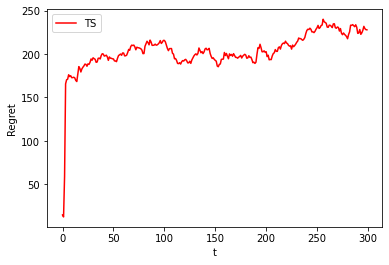

In [68]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis=0)), 'r')
plt.legend(["TS"])
plt.show()

In [66]:
print("_______________________________________________")
print("Considering all the experiments:")
print("-----------------------------------------------")
print("Total expected reward over",n_days, "days and its standard deviation considering", n_experiments,"experiments")
print(np.mean(np.sum(ts_rewards_per_experiment, axis=1)),np.std(np.sum(ts_rewards_per_experiment, axis = 1)))
print("-----------------------------------------------")
print("Total expected regret over",n_days, "days and its standard deviation considering", n_experiments,"experiments")
print(np.mean(np.sum(opt - ts_rewards_per_experiment, axis = 1)), np.std(np.sum(opt - ts_rewards_per_experiment, axis=1)))

print("-----------------------------------------------")
print("Average expected reward per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print(np.mean(np.mean(ts_rewards_per_experiment, axis=0)), np.std(np.mean(ts_rewards_per_experiment, axis=0)))
print("-----------------------------------------------")
print("Average expected regret per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print(np.mean(np.mean(opt-ts_rewards_per_experiment, axis=0)), np.std(np.mean(opt-ts_rewards_per_experiment, axis=0)))


_______________________________________________
Considering all the experiments:
-----------------------------------------------
Total expected reward over 1000 days and its standard deviation considering 5 experiments
136869.10009678654 91.54128416095237
-----------------------------------------------
Total expected regret over 1000 days and its standard deviation considering 5 experiments
136.8485296888087 91.54128416095372
-----------------------------------------------
Average expected reward per round over 1000 days and its standard deviation between the rounds considering 5 experiments
136.86910009678658 4.698054477087994
-----------------------------------------------
Average expected regret per round over 1000 days and its standard deviation between the rounds considering 5 experiments
0.13684852968880873 4.698054477087994


Text(0.5, 1.0, 'Expected regret per round')

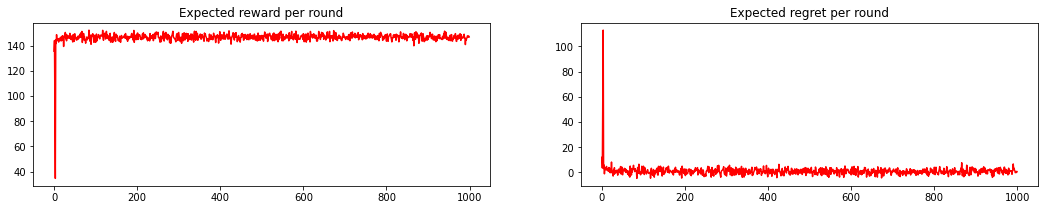

In [33]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,3))
ax[0].plot((np.mean(ts_rewards_per_experiment, axis=0)), 'r')
ax[0].set_title("Expected reward per round")
ax[1].plot((np.mean(opt-ts_rewards_per_experiment, axis=0)), 'r')
ax[1].set_title("Expected regret per round")

In [34]:
#Considering one experiment to have an idea about expected rewards per arm and number of pulls per arm
print("_______________________________________________")
print("Expected rewards per arm for the last experiment")    
print(ts_learner.expected_rewards)
print("_______________________________________________")
print("Pulls per arm for the last experiment")
for i in range(5):
    pulls_per_arm = [len(ts_learner.rewards_per_arm[i][0])-1,len(ts_learner.rewards_per_arm[i][1])-1,len(ts_learner.rewards_per_arm[i][2])-1,len(ts_learner.rewards_per_arm[i][3])-1]

    print(pulls_per_arm)

_______________________________________________
Expected rewards per arm for the last experiment
[[14.74378678 15.24198696 12.54673211  5.72574545]
 [11.54781174 11.6784673   7.59333484  4.3992    ]
 [29.37461905 31.80541477 19.19077273 12.05322857]
 [46.788      50.67748539 29.29158621 27.99578947]
 [31.996      37.83996532 17.4771244   3.26294737]]
_______________________________________________
Pulls per arm for the last experiment
[28, 963, 7, 2]
[63, 934, 2, 1]
[3, 993, 2, 2]
[1, 996, 1, 2]
[1, 996, 2, 1]


In [112]:
from scipy.special import rel_entr
KL = sum(rel_entr([opt for i in range(n_days)],ts_rewards_per_day))
#KL divergence

In [123]:
KL = np.zeros(n_days)
for i in range(n_days):
    KL[i] = opt * np.log(opt/ts_rewards_per_day[i]) 

In [118]:
empiric_regret_ts = np.sum(opt-ts_rewards_per_day)
empiric_regret_ts

203.59599750407682

In [125]:
#Theoretical bounds
delta_ts = opt - ts_rewards_per_day
UPPER_bound_regret_ts = (1+10)*np.log(ts_learner.t)+np.log(np.log(ts_learner.t))*np.sum(delta_ts/KL)
UPPER_bound_regret_ts

583.610202888372

In [106]:
empiric_regret_ts/UPPER_bound_regret_ts

0.3862255433397792

## UCB: : optimization of the cumulative expected margin over all the products

In [76]:
#UCB
n_arms = 4
num_users = 100
n_days = 300
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
n_experiments = 10

ucb_rewards_per_experiment = []

ucb_rewards_per_day_per_experiment = []
ucb_rewards_per_day = np.zeros(n_days)

for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights, fixed_units)
    ucb_learner = UCB(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)
        ucb_rewards_per_day[d] += np.sum(reward)
    


    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)

ucb_rewards_per_day = ucb_rewards_per_day/n_experiments

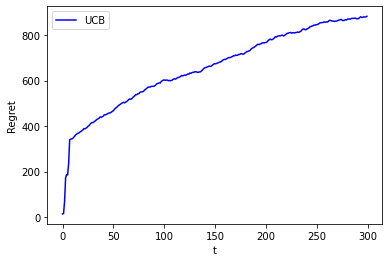

In [71]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')
plt.legend(["UCB"])
plt.show()

In [78]:
print("_______________________________________________")
print("Considering all the experiments:")
print("-----------------------------------------------")
print("Total expected reward over",n_days, "days and its standard deviation between", n_experiments,"experiments")
print(np.mean(np.sum(ucb_rewards_per_experiment, axis=1)),np.std(np.sum(ucb_rewards_per_experiment, axis = 1)))
print("-----------------------------------------------")
print("Total expected regret over",n_days, "days and its standard deviation between", n_experiments,"experiments")
print(np.mean(np.sum(opt - ucb_rewards_per_experiment, axis = 1)), np.std(np.sum(opt - ucb_rewards_per_experiment, axis=1)))

print("-----------------------------------------------")
print("Average expected reward per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print(np.mean(np.mean(ucb_rewards_per_experiment, axis=0)), np.std(np.mean(ucb_rewards_per_experiment, axis=0)))
print("-----------------------------------------------")
print("Average expected regret per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print(np.mean(np.mean(opt-ucb_rewards_per_experiment, axis=0)), np.std(np.mean(opt-ucb_rewards_per_experiment, axis=0)))


_______________________________________________
Considering all the experiments:
-----------------------------------------------
Total expected reward over 300 days and its standard deviation between 10 experiments
40129.177088922814 152.8929725004206
-----------------------------------------------
Total expected regret over 300 days and its standard deviation between 10 experiments
972.6074990197928 152.89297250042083
-----------------------------------------------
Average expected reward per round over 300 days and its standard deviation between the rounds considering 10 experiments
133.7639236297427 9.501461520174837
-----------------------------------------------
Average expected regret per round over 300 days and its standard deviation between the rounds considering 10 experiments
3.2420249967326424 9.501461520174837


Text(0.5, 1.0, 'Expected regret per round')

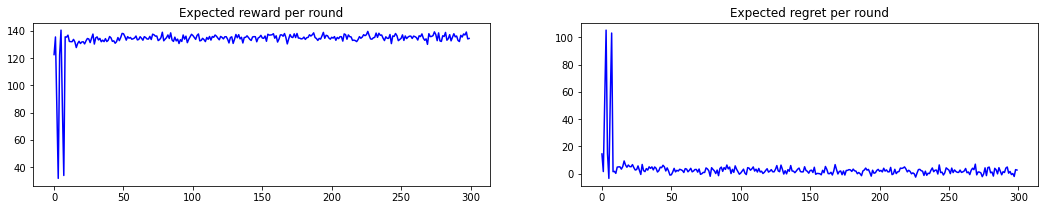

In [79]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,3))
ax[0].plot((np.mean(ucb_rewards_per_experiment, axis=0)), 'b')
ax[0].set_title("Expected reward per round")
ax[1].plot((np.mean(opt-ucb_rewards_per_experiment, axis=0)), 'b')
ax[1].set_title("Expected regret per round")

In [80]:
#Considering one experiment to have an idea about expected rewards per arm and number of pulls per arm
print("_______________________________________________")
print("Expected rewards per arm for the last experiment")    
print(ucb_learner.expected_rewards)
print("_______________________________________________")
print("Pulls per arm for the last experiment")
for i in range(5):
    pulls_per_arm = [len(ucb_learner.rewards_per_arm[i][0])-1,len(ucb_learner.rewards_per_arm[i][1])-1,len(ucb_learner.rewards_per_arm[i][2])-1,len(ucb_learner.rewards_per_arm[i][3])-1]

    print(pulls_per_arm)

print("_______________________________________________")
print("Upper confidence bounds for the last experiment")
print(ucb_learner.confidence)

_______________________________________________
Expected rewards per arm for the last experiment
[[ 7.59979223  9.18626054  8.40580854  2.337075  ]
 [ 5.72976946  6.82242126  5.16955069  0.421     ]
 [22.77569478 25.62125671 18.82822983  1.39975   ]
 [46.53343378 50.30045763 30.36308027 13.89166071]
 [39.995      45.10867455 16.9026161   1.94430556]]
_______________________________________________
Pulls per arm for the last experiment
[21, 226, 51, 2]
[24, 261, 13, 2]
[43, 242, 13, 2]
[51, 245, 2, 2]
[43, 253, 2, 2]
_______________________________________________
Upper confidence bounds for the last experiment
[[0.72747627 0.22466854 0.47280737 1.44202689]
 [0.68001692 0.20906254 0.91169136 1.44202689]
 [0.51384342 0.21711448 0.92298298 1.44202689]
 [0.46412733 0.21578111 1.39495883 1.44202689]
 [0.51476314 0.21234215 1.39495883 1.44202689]]


In [90]:
#Theoretical comparison (?)

opt_per_product = np.zeros(5)
delta_arms_per_product = np.zeros((5,4)) #differencees with the mean reward of the optimal arm
upper_bound_regret_per_product = np.zeros(5)
for i in range(5):
    opt_per_product[i] = np.max(margins_matrix[i,:] * conversion_rates[i])
    for j in range(4):
        delta_arms_per_product[i,j] = opt_per_product[i] - ucb_learner.expected_rewards[i,j]
        if delta_arms_per_product[i,j]>0:
            upper_bound_regret_per_product[i] += 4*np.log(ucb_learner.t)/delta_arms_per_product[i,j] + 8*delta_arms_per_product[i,j]
   

delta = opt - ucb_rewards_per_day
UPPER_bound_regret = 4*np.log(ucb_learner.t)*np.sum(1/delta+8*delta)

#R(UCB)<SUM(4*np.log(ucb_learner.t)/delta_arms_per_product[i,j] + 8*delta_arms_per_product[i,j])
print("Upper bound theoretical regret per product")
print(upper_bound_regret_per_product)
print("Ratio between empiric regret and the upper bound")
empiric_regret = np.mean(np.sum(opt - ucb_rewards_per_experiment, axis = 1))
print(empiric_regret/np.sum(upper_bound_regret_per_product))

Upper bound theoretical regret per product
[ 28.03105756 335.21456748  59.54726387  31.13295344 611.10911508]
Ratio between empiric regret and the upper bound
0.9132165026526253


In [92]:
UPPER_bound_regret
EMPIRIC_regret = np.sum(opt-ucb_rewards_per_day)

In [94]:
EMPIRIC_regret/UPPER_bound_regret

0.005345817633601281

Greedy Learner: each round chose the current best solution

In [41]:
# (INUTILE)
#Greedy Learner
n_arms = 4

num_users = 100
n_days = 1000
fixed_alpha = 1
fixed_weights = 1
margins_matrix = np.array([[2.,  5.,  8., 11.], [4.,  7., 10., 13.],[6.,  9., 12., 15.],[ 8., 11., 14., 17],[10., 13., 16., 19.]])

env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights, fixed_units=1)
gr_learner = Greedy(n_arms=n_arms)

for d in range(n_days):
    
    pulled_arm = gr_learner.pull_arm(env.margins_matrix)
    reward = env.round(pulled_arm)
    gr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day)

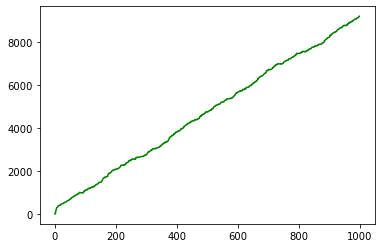

In [42]:
plt.plot(np.cumsum(opt-gr_learner.collected_rewards),'g')